## [Bayesian Regression - Introduction](http://pyro.ai/examples/bayesian_regression.html#Bayesian-Regression---Introduction-(Part-1))

In [1]:
import os

In [2]:
import numpy as np
import pandas as pd

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
import torch
import pyro

In [5]:
from functools import partial

In [6]:
import pyro.distributions as dist

In [7]:
DATA_URL = "https://d2hg8soec8ck9v.cloudfront.net/datasets/rugged_data.csv"
data = pd.read_csv(DATA_URL, encoding="ISO-8859-1")
df = data[["cont_africa", "rugged", "rgdppc_2000"]]
df = df[np.isfinite(df.rgdppc_2000)]
df["rgdppc_2000"] = np.log(df["rgdppc_2000"])

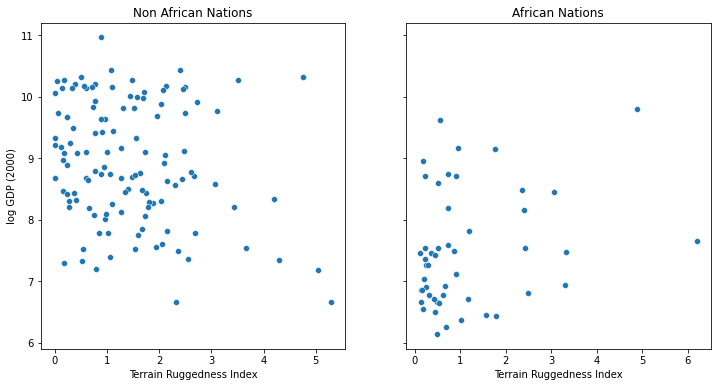

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
african_nations = df[df["cont_africa"] == 1]
non_african_nations = df[df["cont_africa"] == 0]
sns.scatterplot(x=non_african_nations["rugged"],
                y=non_african_nations["rgdppc_2000"],
                ax=ax[0])
ax[0].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="Non African Nations")
sns.scatterplot(x=african_nations["rugged"],
                y=african_nations["rgdppc_2000"],
                ax=ax[1])
ax[1].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="African Nations");

In [9]:
from torch import nn
from pyro.nn import PyroModule

In [10]:
assert issubclass(PyroModule[nn.Linear], nn.Linear)
assert issubclass(PyroModule[nn.Linear], PyroModule)

In [11]:
df["cont_africa_x_rugged"] = df["cont_africa"] * df["rugged"]

data = torch.tensor(df[["cont_africa", "rugged", "cont_africa_x_rugged", "rgdppc_2000"]].values,
                        dtype=torch.float)
x_data, y_data = data[:, :-1], data[:, -1]

In [12]:
x_data.shape

torch.Size([170, 3])

In [13]:
y_data.shape

torch.Size([170])

In [14]:
lr_model = PyroModule[nn.Linear](3,1)

In [15]:
loss_fn = torch.nn.MSELoss(reduction='sum')
optim = torch.optim.Adam(lr_model.parameters(), lr=0.05)
num_iterations = 1500

In [16]:
def train():
    y_pred = lr_model(x_data).squeeze(-1)
    loss = loss_fn(y_pred, y_data)
    optim.zero_grad()
    loss.backward()
    optim.step()
    return loss

In [17]:
for j in range(num_iterations):
    loss = train()
    if (j+1) % 50 == 0:
        print("[iteration %04d] loss: %.4f" % (j+1, loss.item()))

[iteration 0050] loss: 4085.1362
[iteration 0100] loss: 2051.9172
[iteration 0150] loss: 1330.6503
[iteration 0200] loss: 985.6724
[iteration 0250] loss: 766.7665
[iteration 0300] loss: 606.1200
[iteration 0350] loss: 481.5304
[iteration 0400] loss: 384.9879
[iteration 0450] loss: 311.9943
[iteration 0500] loss: 258.4791
[iteration 0550] loss: 220.4550
[iteration 0600] loss: 194.2543
[iteration 0650] loss: 176.7347
[iteration 0700] loss: 165.3609
[iteration 0750] loss: 158.1898
[iteration 0800] loss: 153.7982
[iteration 0850] loss: 151.1859
[iteration 0900] loss: 149.6766
[iteration 0950] loss: 148.8297
[iteration 1000] loss: 148.3683
[iteration 1050] loss: 148.1243
[iteration 1100] loss: 147.9991
[iteration 1150] loss: 147.9368
[iteration 1200] loss: 147.9067
[iteration 1250] loss: 147.8926
[iteration 1300] loss: 147.8863
[iteration 1350] loss: 147.8835
[iteration 1400] loss: 147.8823
[iteration 1450] loss: 147.8819
[iteration 1500] loss: 147.8816


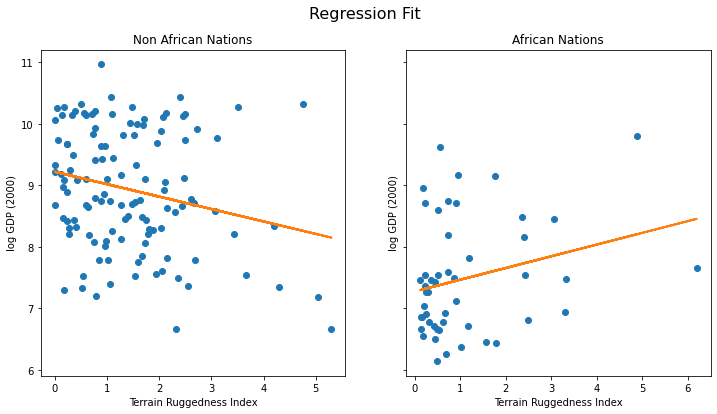

In [18]:
fit = df.copy()
fit["mean"] = lr_model(x_data).detach().cpu().numpy()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
african_nations = fit[fit["cont_africa"] == 1]
non_african_nations = fit[fit["cont_africa"] == 0]
fig.suptitle("Regression Fit", fontsize=16)
ax[0].plot(non_african_nations["rugged"], non_african_nations["rgdppc_2000"], "o")
ax[0].plot(non_african_nations["rugged"], non_african_nations["mean"], linewidth=2)
ax[0].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="Non African Nations")
ax[1].plot(african_nations["rugged"], african_nations["rgdppc_2000"], "o")
ax[1].plot(african_nations["rugged"], african_nations["mean"], linewidth=2)
ax[1].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="African Nations");

### Bayesian Regression Model

In [19]:
from pyro.nn import PyroSample

In [20]:
class BR(PyroModule):
    def __init__(self, in_features, out_target):
        super().__init__()
        self.linear = PyroModule[nn.Linear](in_features, out_target)
        # The BayesianRegression module internally uses the same PyroModule[nn.Linear] module. 
        # However, note that we replace the weight and the bias of the this module with PyroSample statements. 
        # These statements allow us to place a prior over the weight and bias parameters, 
        # instead of treating them as fixed learnable parameters. For the bias component, 
        # we set a reasonably wide prior since it is likely to be substantially above 0.
        self.linear.weight = PyroSample(dist.Normal(0.0,1.).expand([out_target, in_features]).to_event(2))
        self.linear.bias = PyroSample(dist.Normal(0., 10.).expand([out_target]).to_event(1))

    def forward(self, x, y=None):
        sigma = pyro.sample("sigma", dist.Uniform(0.,10.))
        mean = self.linear(x).squeeze(-1)
        with pyro.plate("data", x.shape[0]):
            # we use the obs argument to the pyro.sample statement to condition on the observed data y_data 
            # with a learned observation noise sigma
            obs = pyro.sample("obs", dist.Normal(mean, sigma), obs=y)
        return mean

 Gaussian with diagonal covariance, i.e. it assumes that there is no correlation amongst the latent variables (quite a strong modeling assumption as we shall see i

In [21]:
from pyro.infer.autoguide import AutoDiagonalNormal

In [22]:
model = BR(3,1)
guide = AutoDiagonalNormal(model)

In [23]:
from pyro.infer import SVI, Trace_ELBO

In [24]:
adam = pyro.optim.Adam({"lr":0.03})
svi = SVI(model, guide, adam, loss=Trace_ELBO())

In [25]:
pyro.clear_param_store()

for j in range(1000):
    loss = svi.step(x_data, y_data)
    if j % 100 == 0:
        print("[iteration %04d] loss: %.4f" % (j+1, loss / (len(data))))

[iteration 0001] loss: 7.2417
[iteration 0101] loss: 3.5456
[iteration 0201] loss: 3.2609
[iteration 0301] loss: 3.1045
[iteration 0401] loss: 2.8443
[iteration 0501] loss: 2.4181
[iteration 0601] loss: 1.8078
[iteration 0701] loss: 1.4817
[iteration 0801] loss: 1.4801
[iteration 0901] loss: 1.4560


In [40]:
guide.requires_grad_(False)

AutoDiagonalNormal()

In [26]:
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name))

AutoDiagonalNormal.loc Parameter containing:
tensor([-2.2638, -1.8540, -0.1907,  0.3193,  9.1701], requires_grad=True)
AutoDiagonalNormal.scale tensor([0.0641, 0.1371, 0.0417, 0.0939, 0.0757], grad_fn=<SoftplusBackward0>)


In [27]:
guide.quantiles([0.25, 0.5, 0.75])

{'sigma': tensor([0.9054, 0.9416, 0.9792]),
 'linear.weight': tensor([[[-1.9465, -0.2188,  0.2560]],
 
         [[-1.8540, -0.1907,  0.3193]],
 
         [[-1.7616, -0.1626,  0.3826]]]),
 'linear.bias': tensor([[9.1190],
         [9.1701],
         [9.2212]])}

### Model Evaluation

In [28]:
from pyro.infer import Predictive

In [36]:
preds =  Predictive(model, guide=guide, num_samples=800, return_sites=("linear.weight", 'obs',"_RETURN"))
samples = preds(x_data)

In [31]:
def summary(samples):
    site_stats = {}
    for k, v in samples.items():
        site_stats[k] = {
            "mean": torch.mean(v,0),
            "std": torch.std(v,0),
            "5%": v.kthvalue(int(len(v)*0.05), dim=0)[0],
            "95%": v.kthvalue(int(len(v)*0.95), dim=0)[0],            
        }
    return site_stats

In [37]:
pred_summary = summary(samples)

In [40]:
mu = pred_summary['_RETURN']
y = pred_summary["obs"]

predictions = pd.DataFrame({
    "cont_africa": x_data[:, 0],
    "rugged": x_data[:, 1],
    "mu_mean": mu["mean"],
    "mu_perc_5": mu["5%"],
    "mu_perc_95": mu["95%"],
    "y_mean": y["mean"],
    "y_perc_5": y["5%"],
    "y_perc_95": y["95%"],
    "true_gdp": y_data,
})

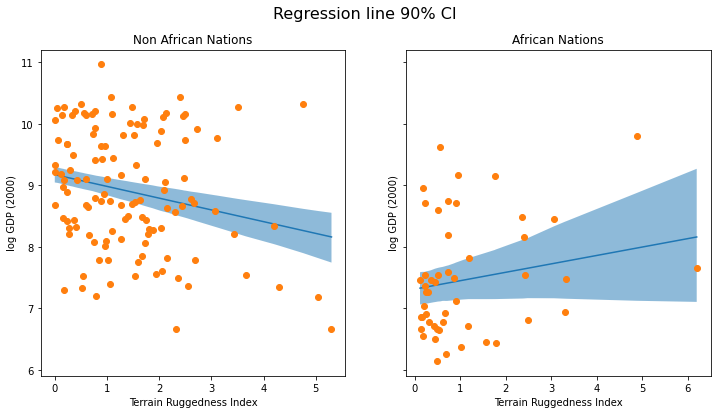

In [45]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)

african_nations = predictions[predictions["cont_africa"] == 1]
non_african_nations = predictions[predictions["cont_africa"] == 0]
african_nations = african_nations.sort_values(by=["rugged"])
non_african_nations = non_african_nations.sort_values(by=["rugged"])

fig.suptitle("Regression line 90% CI", fontsize=16)

ax[0].plot(non_african_nations["rugged"],
           non_african_nations["mu_mean"])

ax[0].fill_between(non_african_nations["rugged"],
                   non_african_nations["mu_perc_5"],
                   non_african_nations["mu_perc_95"],
                   alpha=0.5) 

ax[0].plot(non_african_nations["rugged"],
           non_african_nations["true_gdp"],
           "o")     

ax[0].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="Non African Nations")
idx = np.argsort(african_nations["rugged"])
ax[1].plot(african_nations["rugged"],
           african_nations["mu_mean"])
ax[1].fill_between(african_nations["rugged"],
                   african_nations["mu_perc_5"],
                   african_nations["mu_perc_95"],
                   alpha=0.5)
ax[1].plot(african_nations["rugged"],
           african_nations["true_gdp"],
           "o")
ax[1].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="African Nations");     

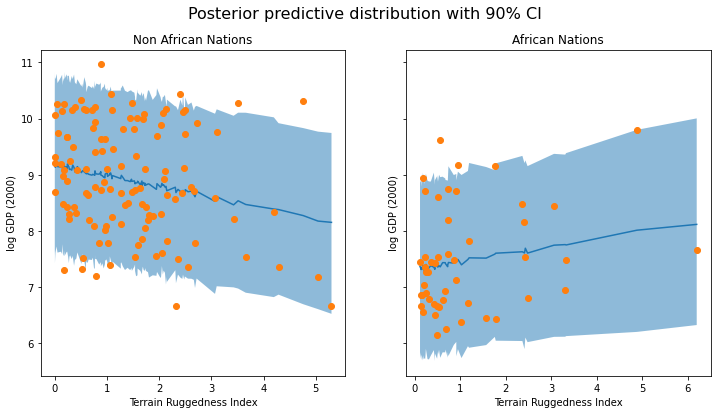

In [49]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
fig.suptitle("Posterior predictive distribution with 90% CI", fontsize=16)
ax[0].plot(non_african_nations["rugged"],
           non_african_nations["y_mean"])

ax[0].fill_between(non_african_nations["rugged"],
                   non_african_nations["y_perc_5"],
                   non_african_nations["y_perc_95"],
                   alpha=0.5)

ax[0].plot(non_african_nations["rugged"],
           non_african_nations["true_gdp"],
           "o")

ax[0].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="Non African Nations")
idx = np.argsort(african_nations["rugged"])

ax[1].plot(african_nations["rugged"],
           african_nations["y_mean"])
ax[1].fill_between(african_nations["rugged"],
                   african_nations["y_perc_5"],
                   african_nations["y_perc_95"],
                   alpha=0.5)
ax[1].plot(african_nations["rugged"],
           african_nations["true_gdp"],
           "o")
ax[1].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="African Nations");

In [51]:
weight = samples["linear.weight"]
weight = weight.reshape(weight.shape[0], 3)

In [52]:
gamma_within_africa = weight[:, 1] + weight[:, 2]
gamma_outside_africa = weight[:, 1]

/home/dulunche/.local/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/dulunche/.local/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


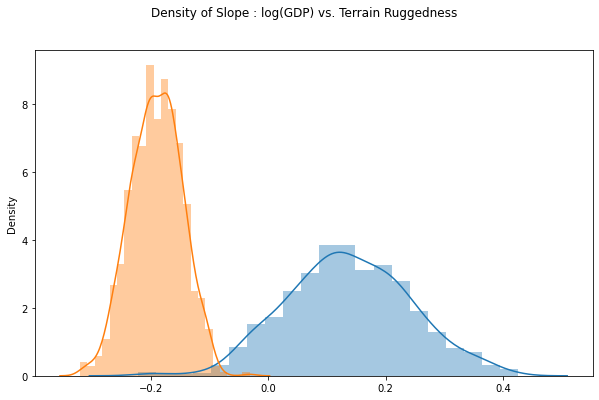

In [53]:
fig = plt.figure(figsize=(10, 6))
sns.distplot(gamma_within_africa, kde_kws={"label": "African nations"},)
sns.distplot(gamma_outside_africa, kde_kws={"label": "Non-African nations"})
fig.suptitle("Density of Slope : log(GDP) vs. Terrain Ruggedness");

## Model Serving via TorchScript

Finally, note that the model, guide and the Predictive utility class are all torch.nn.Module instances, and can be serialized as TorchScript.

In [54]:
from collections import defaultdict
from pyro import poutine
from pyro.poutine.util import prune_subsample_sites
import warnings

In [57]:
class Predict(torch.nn.Module):
    def __init__(self, model, guide) -> None:
        super().__init__()
        self.model = model
        self.guide = guide

    def forward(self, *args, **kwargs):
        samples = {}
        guide_trace = poutine.trace(self.guide).get_trace(*args, **kwargs)
        model_trace = poutine.trace(poutine.replay(self.model, guide_trace)).get_trace(*args, **kwargs)
        for site in prune_subsample_sites(model_trace).stochastic_nodes:
            samples[site] = model_trace.nodes[site]['value']
        return tuple(v for _, v in sorted(samples.items()))

In [58]:
predict_fn = Predict(model, guide)

In [59]:
predict_module = torch.jit.trace_module(predict_fn, {"forward": (x_data,)}, check_trace=False)

In [60]:
torch.jit.save(predict_module, '/tmp/reg_predict.pt')
pred_loaded = torch.jit.load('/tmp/reg_predict.pt')

In [63]:
pred_loaded(x_data)[1]

tensor([[-1.6688, -0.1733,  0.1480]], grad_fn=<ExpandBackward0>)

In [62]:
weight = []
for _ in range(800):
    # index = 1 corresponds to "linear.weight"
    weight.append(pred_loaded(x_data)[1])

In [64]:
weight = torch.stack(weight).detach()

In [65]:
weight.shape

torch.Size([800, 1, 3])

In [66]:
weight = weight.reshape(weight.shape[0], 3)

/home/dulunche/.local/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/dulunche/.local/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


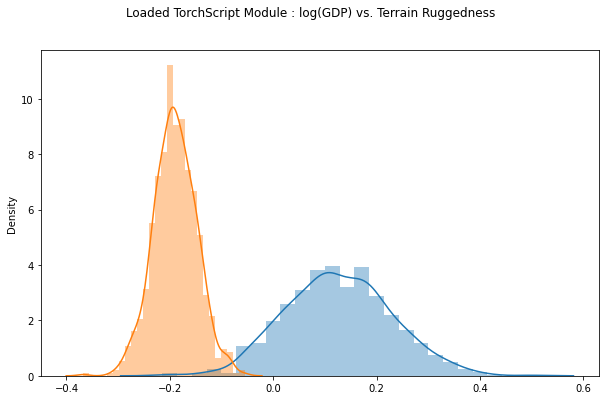

In [67]:
gamma_within_africa = weight[:, 1] + weight[:, 2]
gamma_outside_africa = weight[:, 1]
fig = plt.figure(figsize=(10, 6))
sns.distplot(gamma_within_africa, kde_kws={"label": "African nations"},)
sns.distplot(gamma_outside_africa, kde_kws={"label": "Non-African nations"})
fig.suptitle("Loaded TorchScript Module : log(GDP) vs. Terrain Ruggedness");

___

## [Bayesian Regression - Inference Algorithms](http://pyro.ai/examples/bayesian_regression_ii.html#Bayesian-Regression---Inference-Algorithms-(Part-2))